# Self Organizing Method (SOM)

In [1]:
# Mission is to detect potential fraud via clustering

### Importing the Libraries

In [2]:
import numpy as np
import matplotlib as plt
import pandas as pd

### Importing the Dataset

In [3]:
dataset = pd.read_csv('data/som/Credit_Card_Applications.csv')

In [4]:
X = dataset.iloc[:, :-1].values

In [5]:
y = dataset.iloc[:, -1].values

#### Feature Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_scaled = sc.fit_transform(X)

#### Training the SOM

In [7]:
from minisom import MiniSom

In [8]:
# Create the unsupervised graph
# x and y are the size of the grid to show
# imput_len are the number of features in the dataset, we have 14 which includes the ids so 15
# sigma is the radius of the different grids in the neighborhood...we will stick with default 1
# learning_rate - hyper param of how much weights are updated (default None)

som = MiniSom(x=10, y=10, input_len = 15, sigma = 1.0, learning_rate=0.5)

In [9]:
# Initialize the weights
som.random_weights_init(X_scaled)

# Repeat steps 4 -> 9 on training guide
som.train_random(data = X_scaled, num_iteration = 100)

#### Visualize the Results

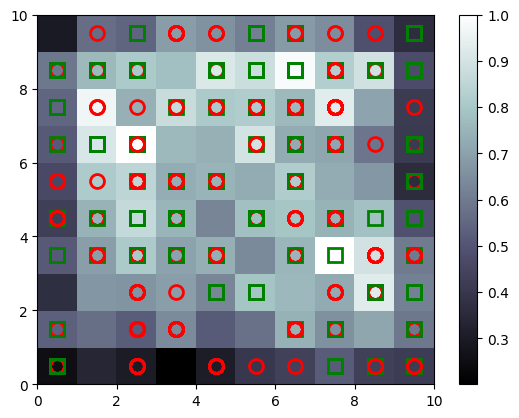

In [10]:
# MID = Mean Internodal Distance
from pylab import bone, pcolor, colorbar, plot, show

# initialize the figure
bone()

# colors are the distances
# som.distance_map() returns the mean interneuron distances as a matrix (array of arrays)
pcolor(som.distance_map().T) # transpose for right order for p value method

# legend (normalized)
colorbar() # whites are outliers and potential frauds

# Lets make this clearer
markers = ['o', 's'] # circle and square
colors = ['r', 'g'] 

# loop over each customer 
# red if not approved, green if approved

for i, x in enumerate(X_scaled): # i is index, x is the vector of that customer
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5, # put at center of winning node inside the square
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2) # make it a circle or square and red or green based on the actual output




#### Identify the cheaters / Catching the Bad Guys

In [26]:
mappings = som.win_map(X_scaled)
frauds = np.concatenate((mappings[(2,6)], mappings[(1,7)]), axis = 0)
frauds_final = sc.inverse_transform(frauds) # Inverse the scaling
pd.DataFrame(frauds_final) # Column 0 will be the customer Ids that potentially frauded the system


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,15585855.0,1.0,40.25,21.500,2.0,10.0,9.0,20.000,1.0,1.0,11.0,0.0,2.0,0.0,1201.0
1,15661412.0,1.0,48.75,8.500,2.0,8.0,8.0,12.500,1.0,1.0,9.0,0.0,2.0,181.0,1656.0
2,15723827.0,1.0,76.75,22.290,2.0,10.0,9.0,12.750,1.0,1.0,1.0,1.0,2.0,0.0,110.0
3,15589881.0,1.0,28.92,15.000,2.0,8.0,8.0,5.335,1.0,1.0,11.0,0.0,2.0,0.0,2284.0
4,15671293.0,1.0,54.83,15.500,2.0,10.0,9.0,0.000,1.0,1.0,20.0,0.0,2.0,152.0,131.0
5,15602456.0,1.0,48.17,7.625,2.0,9.0,8.0,15.500,1.0,1.0,12.0,0.0,2.0,0.0,791.0
6,15697844.0,1.0,57.42,8.500,2.0,10.0,8.0,7.000,1.0,1.0,3.0,0.0,2.0,0.0,1.0
7,15580579.0,1.0,43.25,25.210,2.0,11.0,8.0,0.210,1.0,1.0,1.0,0.0,2.0,760.0,91.0
8,15793825.0,0.0,31.92,3.125,2.0,1.0,1.0,3.040,0.0,1.0,2.0,1.0,2.0,200.0,5.0
9,15696361.0,0.0,31.57,1.500,2.0,1.0,1.0,0.000,0.0,1.0,2.0,1.0,2.0,200.0,106.0


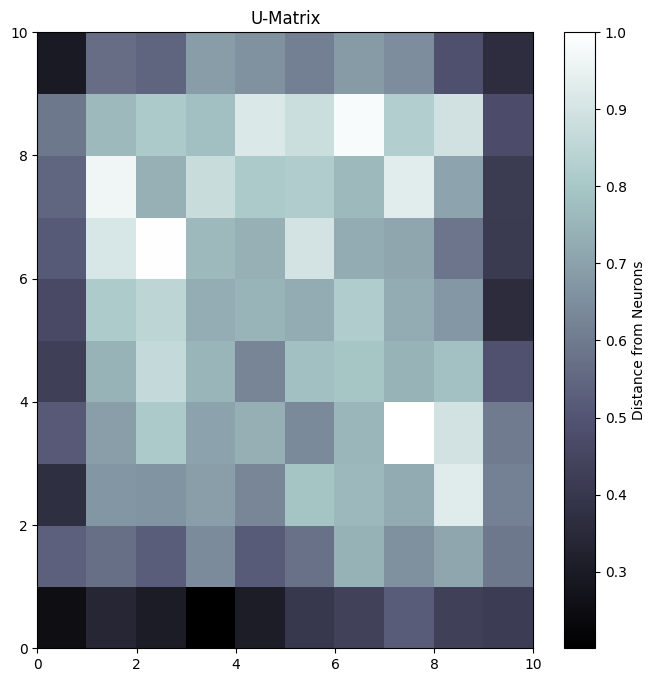

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='bone')  # Transposed for better orientation
plt.colorbar(label='Distance from Neurons')
plt.title('U-Matrix')
plt.show()


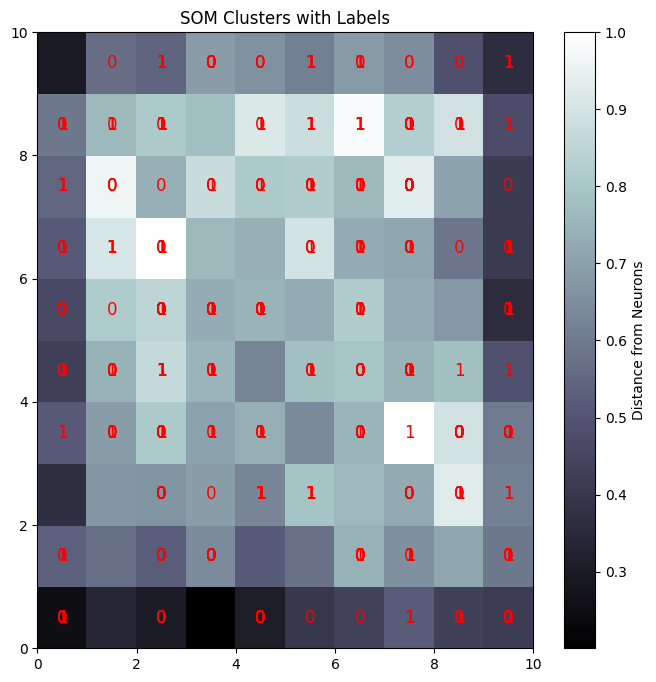

In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 8))
for i, x in enumerate(X_scaled):
    w = som.winner(x)  # Get the winning neuron
    plt.text(w[0] + 0.5, w[1] + 0.5, str(y[i]), color='red', fontsize=12,
             ha='center', va='center')  # Add label at the neuron

plt.pcolor(som.distance_map().T, cmap='bone')  # Background U-Matrix
plt.colorbar(label='Distance from Neurons')
plt.title('SOM Clusters with Labels')
plt.show()


Number of clusters found: 6


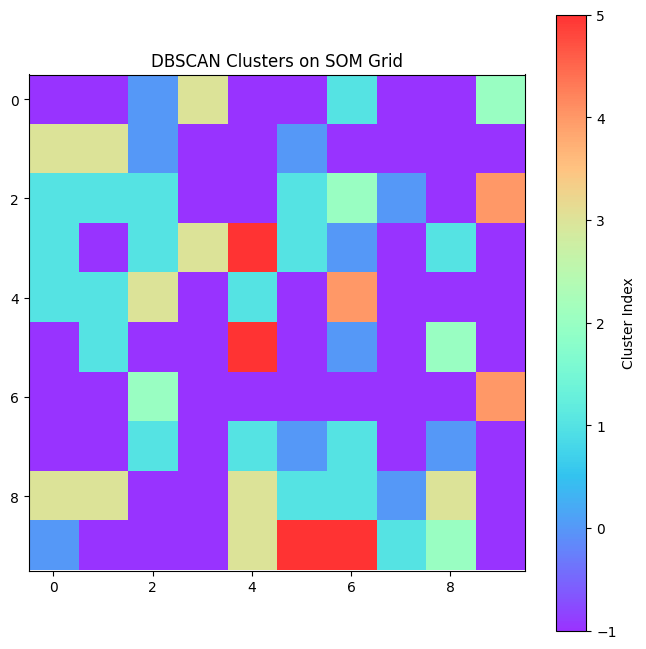

In [14]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Flatten the SOM weights
weights_flat = som.get_weights().reshape(-1, X_scaled.shape[1])

# Apply DBSCAN (you may need to tune `eps` and `min_samples`)
dbscan = DBSCAN(eps=0.5, min_samples=3).fit(weights_flat)

# Extract cluster labels (-1 indicates noise points)
cluster_labels = dbscan.labels_
unique_clusters = len(set(cluster_labels) - {-1})  # Exclude noise

# Reshape cluster labels to the SOM grid
clusters = cluster_labels.reshape(som.get_weights().shape[:2])

print(f"Number of clusters found: {unique_clusters}")

# Visualize the clusters
plt.figure(figsize=(8, 8))
plt.imshow(clusters, cmap='rainbow', alpha=0.8)
plt.colorbar(label='Cluster Index')
plt.title('DBSCAN Clusters on SOM Grid')
plt.show()


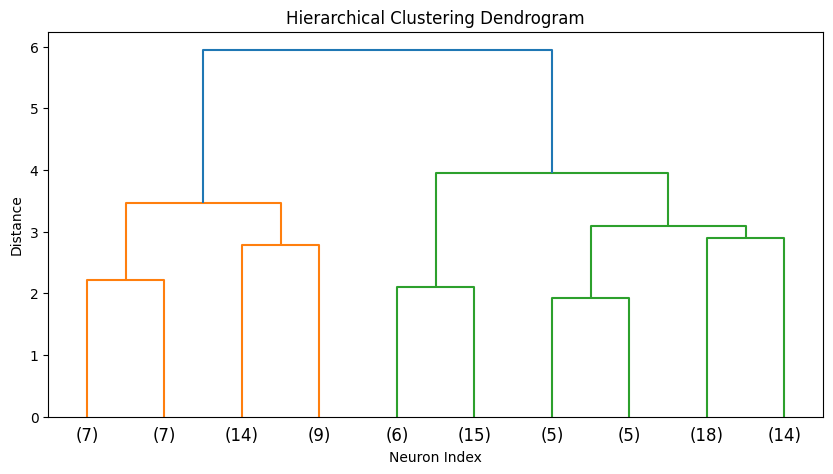

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Flatten the SOM weights
weights_flat = som.get_weights().reshape(-1, X_scaled.shape[1])

# Perform hierarchical clustering
Z = linkage(weights_flat, method='ward')

# Plot dendrogram to visualize clusters
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='lastp', p=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neuron Index')
plt.ylabel('Distance')
plt.show()




In [16]:
# Decide the number of clusters based on the dendrogram
num_clusters = 6  # Adjust threshold based on the plot
cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')

In [17]:
cluster_labels

array([2, 1, 3, 2, 5, 5, 5, 2, 4, 2, 6, 6, 3, 5, 1, 3, 1, 3, 2, 3, 6, 6,
       5, 4, 1, 5, 2, 3, 2, 1, 6, 6, 3, 2, 1, 5, 3, 1, 3, 3, 6, 5, 2, 2,
       5, 4, 1, 5, 4, 5, 3, 5, 2, 6, 1, 2, 3, 4, 2, 2, 5, 6, 1, 6, 3, 3,
       4, 4, 2, 1, 2, 4, 6, 5, 6, 3, 6, 3, 3, 5, 2, 2, 2, 3, 2, 5, 5, 3,
       2, 6, 3, 4, 4, 3, 2, 1, 1, 5, 2, 1], dtype=int32)

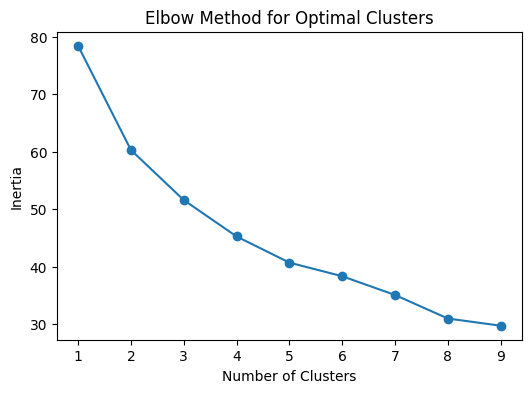

In [18]:
from sklearn.cluster import KMeans

weights_flat = som.get_weights().reshape(-1, X_scaled.shape[1])

inertias = []
for n in range(1, 10):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=n, random_state=42).fit(weights_flat)
    inertias.append(kmeans.inertia_)

# Plot inertia to find the elbow
plt.figure(figsize=(6, 4))
plt.plot(range(1, 10), inertias, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


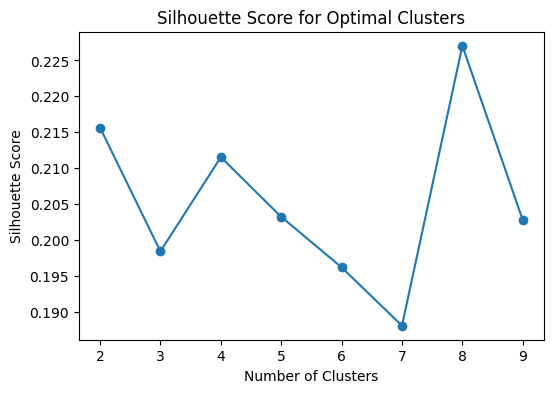

In [19]:
from sklearn.metrics import silhouette_score

weights_flat = som.get_weights().reshape(-1, X_scaled.shape[1])

silhouette_scores = []
for n in range(2, 10):  # Test 2 to 10 clusters
    kmeans = KMeans(n_clusters=n, random_state=42).fit(weights_flat)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(weights_flat, labels))

# Plot silhouette scores
plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


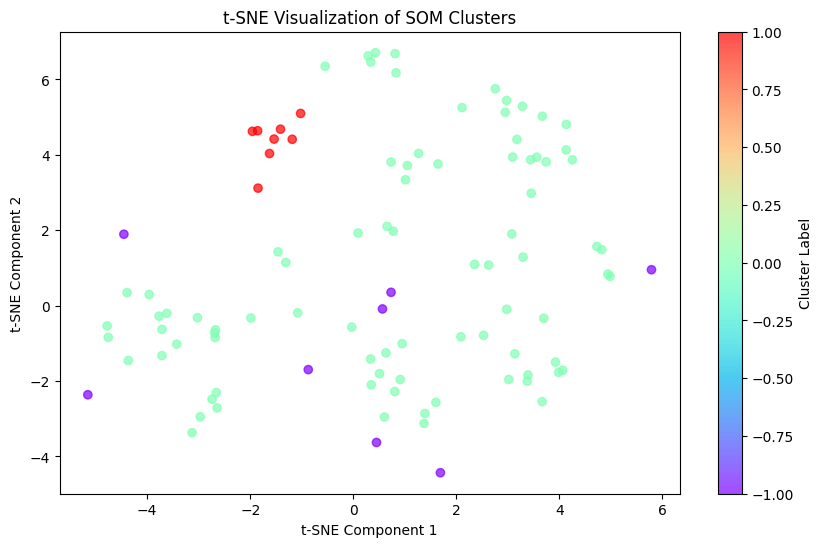

In [41]:
from sklearn.cluster import DBSCAN
import numpy as np

# Flatten SOM weights to (num_neurons, input_dim)
weights_flat = som.get_weights().reshape(-1, X_scaled.shape[1])

# Apply DBSCAN with the detected optimal eps
dbscan = DBSCAN(eps=0.75, min_samples=3).fit(weights_flat)

# Extract cluster labels (-1 indicates noise)
cluster_labels = dbscan.labels_

# Reshape cluster labels to match the SOM grid
clusters = cluster_labels.reshape(som.get_weights().shape[:2])

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality of the neuron weights
tsne = TSNE(n_components=2, random_state=42)
weights_2d = tsne.fit_transform(weights_flat)

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
plt.scatter(weights_2d[:, 0], weights_2d[:, 1], c=cluster_labels, cmap='rainbow', alpha=0.7)
plt.colorbar(label="Cluster Label")
plt.title("t-SNE Visualization of SOM Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


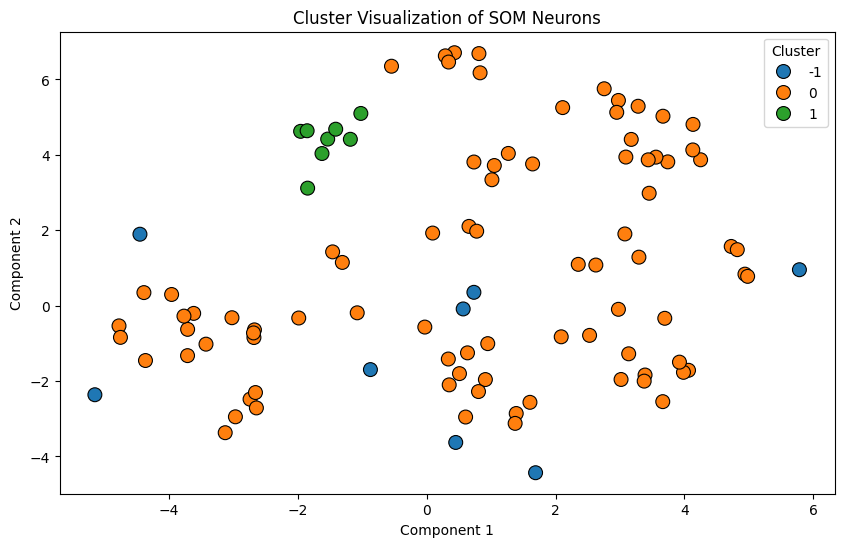

In [42]:
import seaborn as sns
import pandas as pd

# Convert to DataFrame for better plotting
df = pd.DataFrame(weights_2d, columns=['x', 'y'])
df['cluster'] = cluster_labels

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='x', y='y', hue='cluster', palette='tab10', s=100, edgecolor='black')

plt.title("Cluster Visualization of SOM Neurons")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Cluster", loc="best")
plt.show()


In [43]:
import pandas as pd

weights_flat_final = sc.inverse_transform(weights_flat)

# Create a DataFrame with cluster assignments
df_clusters = pd.DataFrame(weights_flat_final, columns=[f'Feature_{i}' for i in range(weights_flat_final.shape[1])])
df_clusters['Cluster'] = cluster_labels




In [44]:
df_clusters[df_clusters['Cluster']==-1]

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Cluster
5,1.581028e+07,0.999389,27.756431,3.032374,1.081486,10.464435,7.941675,5.067926,0.003410,0.928108,1.843298,0.999389,1.990138,364.144533,4.341709,-1
19,1.561479e+07,0.110734,33.549363,1.934441,1.889266,9.056787,7.641298,1.759319,0.200378,0.889324,2.543940,0.152915,2.000000,54.195312,118.036305,-1
39,1.564529e+07,0.003388,50.507774,0.964404,1.124545,2.195276,1.406416,0.942064,0.126433,0.122999,0.239425,0.063787,2.000000,42.108902,112.472500,-1
73,1.575341e+07,0.909425,22.126252,14.470542,2.615729,3.831106,5.955419,0.501588,0.058076,0.046546,0.289693,0.655576,2.572706,384.674051,61592.429574,-1
77,1.562640e+07,0.129232,28.741631,3.273807,1.324596,7.064922,6.148782,0.529790,0.059044,0.057831,0.418468,0.870391,2.000000,220.815819,35.132298,-1
82,1.577541e+07,0.176398,25.610984,1.244312,1.999999,3.176011,1.790812,0.073553,0.928683,0.007065,0.050183,0.001645,1.952982,120.211719,32.863781,-1
92,1.559878e+07,0.976603,47.105463,11.365108,1.999992,7.105048,3.966055,15.011876,0.975741,0.018957,0.115343,0.002968,1.055618,113.123241,13.778204,-1
93,1.574543e+07,0.049858,22.540434,2.361880,2.000000,8.395399,3.433364,0.522753,0.043463,0.939077,2.203153,0.038162,1.963067,124.309141,113.399702,-1


In [45]:
pd.DataFrame(frauds_final)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,15585855.0,1.0,40.25,21.500,2.0,10.0,9.0,20.000,1.0,1.0,11.0,0.0,2.0,0.0,1201.0
1,15661412.0,1.0,48.75,8.500,2.0,8.0,8.0,12.500,1.0,1.0,9.0,0.0,2.0,181.0,1656.0
2,15723827.0,1.0,76.75,22.290,2.0,10.0,9.0,12.750,1.0,1.0,1.0,1.0,2.0,0.0,110.0
3,15589881.0,1.0,28.92,15.000,2.0,8.0,8.0,5.335,1.0,1.0,11.0,0.0,2.0,0.0,2284.0
4,15671293.0,1.0,54.83,15.500,2.0,10.0,9.0,0.000,1.0,1.0,20.0,0.0,2.0,152.0,131.0
5,15602456.0,1.0,48.17,7.625,2.0,9.0,8.0,15.500,1.0,1.0,12.0,0.0,2.0,0.0,791.0
6,15697844.0,1.0,57.42,8.500,2.0,10.0,8.0,7.000,1.0,1.0,3.0,0.0,2.0,0.0,1.0
7,15580579.0,1.0,43.25,25.210,2.0,11.0,8.0,0.210,1.0,1.0,1.0,0.0,2.0,760.0,91.0
8,15793825.0,0.0,31.92,3.125,2.0,1.0,1.0,3.040,0.0,1.0,2.0,1.0,2.0,200.0,5.0
9,15696361.0,0.0,31.57,1.500,2.0,1.0,1.0,0.000,0.0,1.0,2.0,1.0,2.0,200.0,106.0
